# Testing over the final data that was not in the validation or training set

In [1]:
from ultralytics import YOLO
import os
from pathlib import Path
import numpy as np
import cv2
from tqdm import tqdm

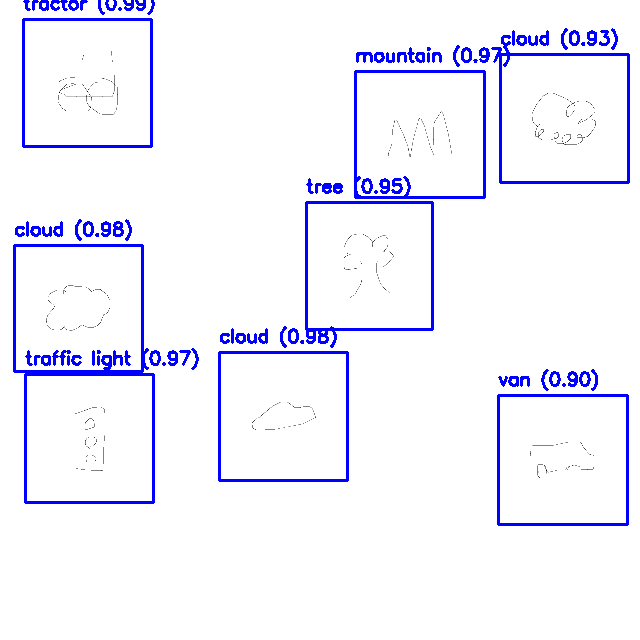

In [2]:
# loading the trained model
model = YOLO('runs/detect/train4/weights/best.pt')

In [3]:
# setting the directory for the images and the labels
test_image_dir = Path('/media/parker/Data_Drive/quick-draw-yolo/images/test')
test_label_dir = Path('/media/parker/Data_Drive/quick-draw-yolo/labels/test')

In [4]:
# assert dirs
assert test_image_dir.exists(), f"Image dir missing: {test_image_dir}"
assert test_label_dir.exists(), f"Label dir missing: {test_label_dir}"

In [5]:
# compute IoU between two boxes
def compute_iou(box1, box2):
    # box format: [x1, y1, x2, y2]
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area else 0

In [6]:
# evaluation loop
total_gt = 0
total_correct = 0

for image_path in tqdm(sorted(test_image_dir.glob("*.png"))):
    # load image
    image = cv2.imread(str(image_path))
    height, width = image.shape[:2]

    # get label file
    label_path = test_label_dir / image_path.with_suffix('.txt').name
    if not label_path.exists():
        continue

    # load ground truth boxes
    gt_boxes = []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            cls, x, y, w, h = map(float, line.strip().split())
            x1 = (x - w / 2) * width
            y1 = (y - h / 2) * height
            x2 = (x + w / 2) * width
            y2 = (y + h / 2) * height
            gt_boxes.append((int(cls), [x1, y1, x2, y2]))

    total_gt += len(gt_boxes)

    # predict
    results = model.predict(source=str(image_path), conf=0.3, verbose=False)
    pred_boxes = []
    for box in results[0].boxes.data.cpu().numpy():
        x1, y1, x2, y2, conf, cls = box
        pred_boxes.append((int(cls), [x1, y1, x2, y2]))

    # match predictions to ground truths
    matched = set()
    for gt_cls, gt_box in gt_boxes:
        for i, (pred_cls, pred_box) in enumerate(pred_boxes):
            if i in matched:
                continue
            iou = compute_iou(gt_box, pred_box)
            if pred_cls == gt_cls and iou > 0.5:
                total_correct += 1
                matched.add(i)
                break

# accuracy summary
print(f"\n Evaluation Summary:")
print(f"Total ground truth boxes: {total_gt}")
print(f"Correct predictions:      {total_correct}")
print(f"Detection Accuracy:       {total_correct / total_gt:.2%}")

100%|██████████| 1000/1000 [00:11<00:00, 89.92it/s]


 Evaluation Summary:
Total ground truth boxes: 5411
Correct predictions:      5201
Detection Accuracy:       96.12%
